In [1]:
import numpy as np
import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import BlockGf

In [2]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 150

Disclaimer: charge self-consistent (CSC) calculations are heavy. The current parameters won't give well converged solution but are tuned down to give results in roughly 150 core hours.

# 2. CSC with VASP PLOs: charge order in PrNiO3

Set the variable `read_from_ref` below to False if you want to plot your own calculated results. Otherwise, the provided reference files are used.

In [3]:
# Reads files from reference? Otherwise, uses your simulation results
read_from_ref = True
path_mod = '/ref' if read_from_ref else ''

PrNiO3 is a perovskite that exhibits a metal-insulator transition coupled to a breathing distortion and charge disproportionation, see [here](https://doi.org/10.1038/s41535-019-0145-4).
In this tutorial, we will run DMFT calculation on the low-temperature insulating state. We will do this in a CSC way, where the correlated orbitals are defined by [projected localized orbitals (PLOs)](https://doi.org/10.1088/1361-648x/aae80a) calculated with VASP.

## 1. Running the initial scf DFT calculation 

(~ 2 core hours)

To get started, we run a self-consistent field (scf) DFT calculation:

* Go into folder `1_dft_scf`
* Insert the POTCAR as concatenation of the files `PAW_PBE Pr_3`, `PAW_PBE Ni_pv` and `PAW_PBE O` distributed with VASP
* Goal: get a well-converged charge density (CHGCAR) and understand where the correlated bands are (DOSCAR and potentially PROCAR and band structure)

Other input files are:

* [INCAR](1_dft_scf/INCAR): using a large number of steps for good convergence. Compared to the DMFT calculation, it is relatively cheap and it is good to have a well converged starting point for DMFT.
* [POSCAR](1_dft_scf/POSCAR): PrNiO3 close to the experimental low-temperature structure (P21/n symmetry)
* [KPOINTS](1_dft_scf/KPOINTS): approximately unidistant grid of 7 x 7 x 5

Then run Vasp with the command `mpirun -n 8 vasp_std`.

The main output here is:

* CHGCAR: the converged charge density to start the DMFT calculation from
* DOSCAR: to identify the energy range of the correlated subspace. (A partial DOS and band structure can be very helpful to identify the correlated subspace as well. The partial DOS can be obtained by uncommenting the LORBIT parameter in the INCAR but then the below functions to plot the DOS need to be adapted.)

We now plot the DFT DOS and discuss the correlated subspace.

In [4]:
dft_energy, dft_dos = np.loadtxt(f'1_dft_scf{path_mod}/DOSCAR',
                                 skiprows=6, unpack=True, usecols=(0, 1))

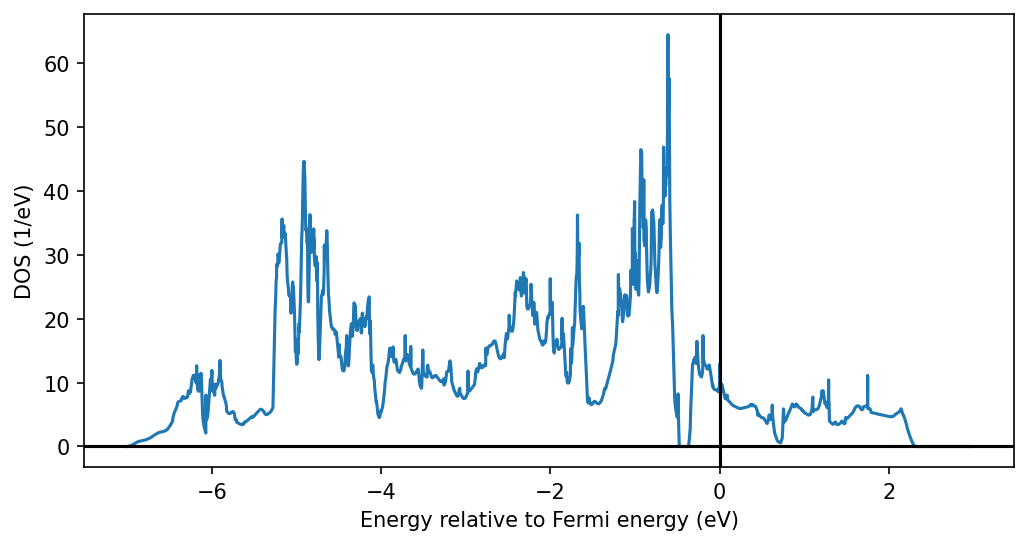

In [5]:
fermi_energy = 5.012206 # can be read from DOSCAR header or OUTCAR

fig, ax = plt.subplots()
ax.plot(dft_energy-fermi_energy, dft_dos)
ax.axhline(0, c='k')
ax.axvline(0, c='k')
ax.set_xlabel('Energy relative to Fermi energy (eV)')
ax.set_ylabel('DOS (1/eV)')
pass

The DOS contains (you can check this with the partial DOS):

* Fe-eg bands in the range -0.4 to 2.5 eV with a small gap at around 0.6 eV
* mainly Fe-t2g bands between -1.5 and -0.5 eV
* mainly O-p bands between -7 and -1.5 eV
The Fe-d and O-p orbitals are hybridized, with an overlap in the DOS betwen Fe-t2g and O-p.

DFT does not describe the system correctly in predicting a metallic state. In a simplified picture, the paramagnetism in DMFT will be able to split the correlated bands and push the Fermi energy into the gap of the eg orbitals, as we will see below.

We will use the Fe-eg range to construct our correlated subspace.

## 2. Running the CSC DMFT calculations

(~ 150 core hours)

We now run the DMFT calculation. In CSC calculations, the corrected charge density from DMFT is fed back into the DFT calculation to re-calculate the Kohn-Sham energies and projectors onto correlated orbitals.

With VASP, the procedure works as described [here](https://triqs.github.io/dft_tools/latest/guide/dftdmft_selfcons.html#vasp-plovasp), where the GAMMA file written by DMFT contains the charge density *correction*. In the VASP-CSC implementation, we first converge a non-scf DFT calculation based on the CHGCAR from before, then run DMFT on the results. The VASP process stays alive but idle during the DMFT calculation. Then, when we want to update the DFT-derived quantities energies, we need to run multiple DFT steps in between the DMFT steps because the density correction is fed into VASP iteratively through mixing to ensure stability. 

### Input files for CSC DMFT calculations

We first take a look into the input file [dmft_config.ini](2_dmft_csc/dmft_config.ini) and discuss some parameters. Please make sure you understand the role of the other parameters as well, as documented in the [reference manual of the read_config.py](https://triqs.github.io/solid_dmft/_ref/read_config.html) on the solid_dmft website. This is a selection of parameters from the dmft_config.ini:

Group [general]:

* `set_rot = hloc`: rotates the local impurity problem into a basis where the local Hamiltonian is diagonal
* `plo_cfg = plo.cfg`: the name of the config file for constructing the PLOs (see below)
* `n_l = 30`: the number of Legendre coefficients to measure the imaginary-time Green's function in. Too few resulting in a "bumpy" Matsubara self-energy, too many include simulation noise. See also https://doi.org/10.1103/PhysRevB.84.075145.
* `dc_dmft = True`: using the DMFT occupations for the double counting is mandatory in CSC calculations. The DFT occupations are not well defined after the first density correction anymore
* `mu_gap_gb2_threshold = 0.05`: the system is treated as gapped if the lattice Green's function at tau=beta/2 goes below the threshold. Then solid_dmft uses MaxEnt to set the chemical potential in the middle of the gap
* `mu_gap_occ_deviation = 0.4`: additional condition for the above described procedure. Only uses MaxEnt if the occupation after a solver run deviates from the target occupation by this value

Group [solver]:

* `measure_G_l = True`: turns on measuring the Green's function in Legendre coefficients

Group [dft]:

* `n_iter = 15`: number of DFT iterations between the DMFT occupations. Should be large enough for the density correction to be fully mixed into the DFT calculation
* `n_cores = 32`: number of cores that DFT is run on. Check how many cores achieve the optimal DFT performance
* `dft_code = vasp`: we are running VASP
* `dft_exec = vasp_std`: the executable is vasp_std and its path is in the ROOT variable in our docker setup  
* `mpi_env = default`: sets the mpi environment
* `projector_type = plo`: chooses PLO projectors

The [plo.cfg](2_dmft_csc/plo.cfg) file is described [here](https://triqs.github.io/dft_tools/latest/guide/conv_vasp.html). The [rotations.dat](2_dmft_csc/rotations.dat) file is generated by diagonalizing the local d-shell density matrix and identifying the least occupied eigenstates as eg states.

### Starting the calculations

Now we can start the calculations:

* Go into the folder `2_dmft_csc`
* Link relevant files like CHGCAR, KPOINTS, POSCAR, POTCAR from previous directory by running `./2_link_files.sh`
* Run with `mpirun -n 32 python3 solid_dmft`

### Analyzing the projectors

Now we plot the DOS of the PLOs we are using to make sure that our correlated subspace works out as expected. You can speed up the calculation of the PLOs by removing the calculation of the DOS from the plo.cfg file.

In [6]:
energies = []
doss = []
for imp in range(4):
    data = np.loadtxt(f'2_dmft_csc{path_mod}/pdos_0_{imp}.dat', unpack=True)
    energies.append(data[0])
    doss.append(data[1:])
    
energies = np.array(energies)
doss = np.array(doss)

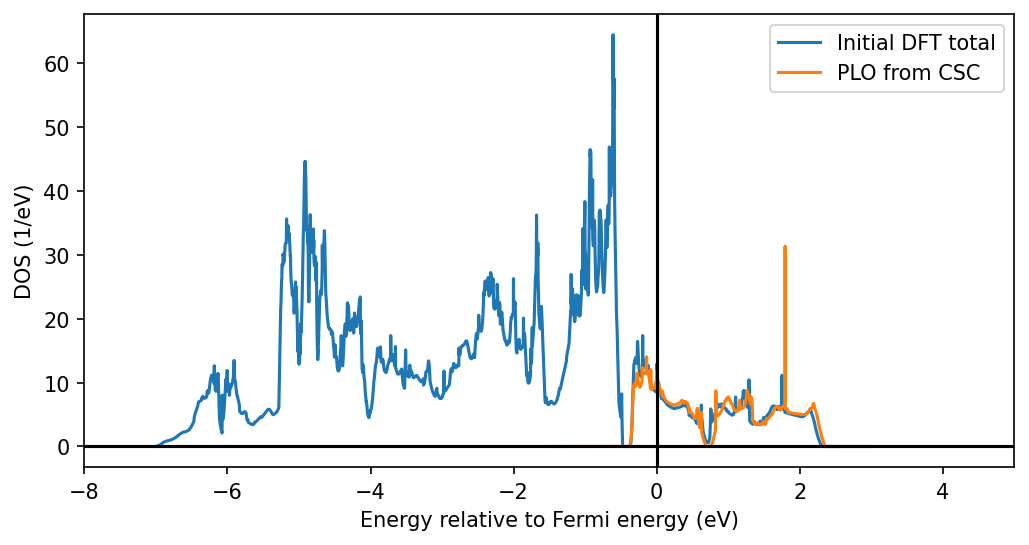

In [7]:
fig, ax = plt.subplots()

ax.plot(dft_energy-fermi_energy, dft_dos, label='Initial DFT total')
ax.plot(energies[0], np.sum(doss, axis=(0, 1)), label='PLO from CSC')
#for energy, dos in zip(energies, doss):
#    ax.plot(energy, dos.T)
ax.axhline(0, c='k')
ax.axvline(0, c='k')
ax.set_xlim(-8, 5)
ax.set_xlabel('Energy relative to Fermi energy (eV)')
ax.set_ylabel('DOS (1/eV)')
ax.legend()
pass

This plot shows the original DFT charge density and the PLO-DOS after applying the DMFT charge corrections. It proves that we are capturing indeed capturing the eg bands with the projectors, where the partial DOS differs a bit because of the changes from the charge self-consistency. Note that this quantity in the CSC DMFT formalism does not have any real meaning, it mainly serves as a check of the method. The correct quantity to analyze are the lattice or impurity Green's functions.

## 3. Plotting the results: observables

We first read in the pre-computed observables from the h5 archive and print their names:

In [8]:
with HDFArchive(f'2_dmft_csc{path_mod}/vasp.h5', 'r') as archive:
    observables = archive['DMFT_results/observables']

In [9]:
observables.keys()

dict_keys(['E_DC', 'E_bandcorr', 'E_corr_en', 'E_dft', 'E_int', 'E_tot', 'imp_gb2', 'imp_occ', 'iteration', 'mu', 'orb_Z', 'orb_gb2', 'orb_occ'])

We will now use this to plot the occupation per impurity `imp_occ` (to see if there is charge disproportionation), the impurity Green's function at $\tau=\beta/2$ `imp_gb2` (to see if the system becomes insulating), the total energy `E_tot` and the DFT energy `E_dft` over the iterations:

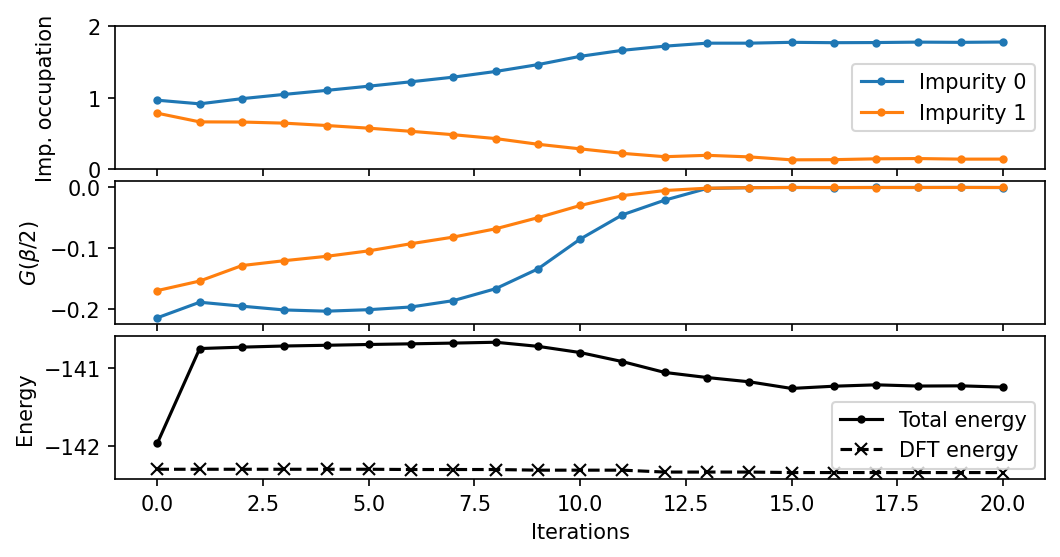

In [10]:
fig, axes = plt.subplots(nrows=3, sharex=True)

for i in range(2):
    axes[0].plot(np.array(observables['imp_occ'][i]['up'])+np.array(observables['imp_occ'][i]['down']), '.-', c=f'C{i}',
                label=f'Impurity {i}')
    axes[1].plot(np.array(observables['imp_gb2'][i]['up'])+np.array(observables['imp_gb2'][i]['down']), '.-', c=f'C{i}')
    
# Not impurity-dependent
axes[2].plot(observables['E_tot'], '.-', c='k', label='Total energy')
axes[2].plot(observables['E_dft'], 'x--', c='k', label='DFT energy')

axes[0].set_ylabel('Imp. occupation\n')
axes[0].set_ylim(0, 2)
axes[0].legend()
axes[1].set_ylabel(r'$G(\beta/2)$')
axes[2].set_ylabel('Energy')
axes[2].legend()

axes[-1].set_xlabel('Iterations')
fig.subplots_adjust(hspace=.08)
pass

These plots show:

* The occupation converges towards a disproportionated 1.8+0.2 electrons state
* Both sites become insulating, which we can deduce from $G(\beta/2)$ from its relation to the spectral function at the Fermi energy $A(\omega = 0) \approx -(\beta/\pi) G(\beta/2)$
* The DFT energy barely changes here (this is qualitatively different for other systems!), and the total energy converges to a different value than the DFT energy once the system has stabilized in the insulating state

Therefore, we can conclude that we managed to capture the desired paramagnetic, insulating state that PrNiO3 shows in the experiments.

## 4. Plotting the results: the Legendre Green's function

We now take a look at the imaginary-time Green's function expressed in Legendre coefficients $G_l$. This is the main solver output (if we are measuring it) and also saved in the h5 archive.

In [11]:
legendre_gf = []
with HDFArchive(f'2_dmft_csc{path_mod}/vasp.h5') as archive:
    for i in range(2):
        legendre_gf.append(archive[f'DMFT_results/last_iter/Gimp_l_{i}'])

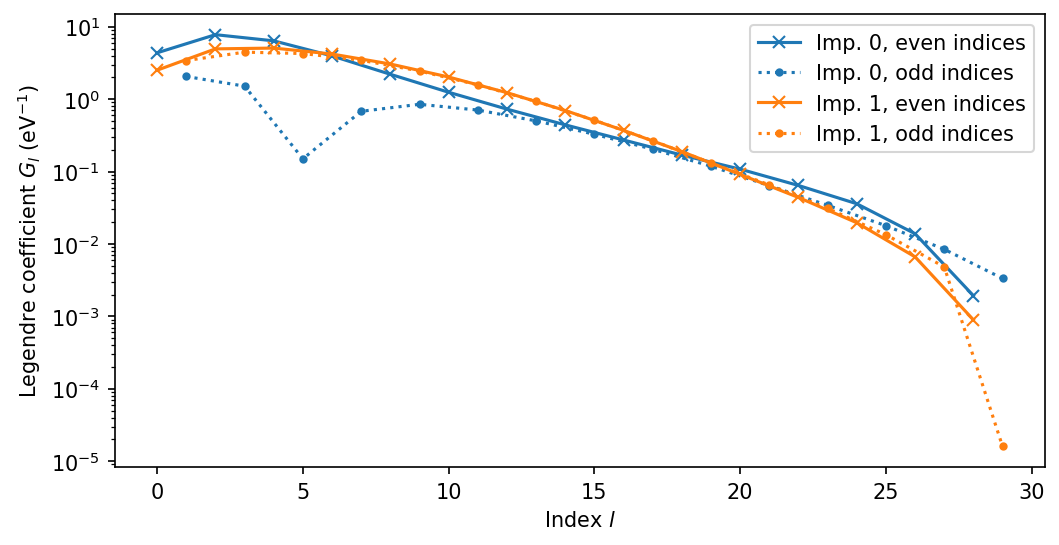

In [12]:
fig, ax = plt.subplots()

for i, legendre_coefficients_per_imp in enumerate(legendre_gf):
    if len(legendre_coefficients_per_imp) != 2:
        raise ValueError('Only blocks up_0 and down_0 supported')

    data = (legendre_coefficients_per_imp['up_0'].data + legendre_coefficients_per_imp['down_0'].data).T

    l_max = data.shape[2]

    ax.semilogy(np.arange(0, l_max, 2), np.abs(np.trace(data[:, :, ::2].real, axis1=0, axis2=1)), 'x-',
                c=f'C{i}', label=f'Imp. {i}, even indices')
    ax.semilogy(np.arange(1, l_max, 2), np.abs(np.trace(data[:, :, 1::2].real, axis1=0, axis2=1)), '.:',
                c=f'C{i}', label=f'Imp. {i}, odd indices')

ax.legend()

ax.set_ylabel('Legendre coefficient $G_l$ (eV$^{-1}$)')
ax.set_xlabel(r'Index $l$')
pass

The choice of the correct `n_l`, i.e., the Legendre cutoff is important. If it is too small, we are ignoring potential information about the Green's function. If it is too large, the noise filtering is not efficient. This can be seen by first running a few iterations with large `n_l`, e.g., 50. Then, the coefficients will first decay exponentially as in the plot above and then at higher $l$ starting showing noisy behavior. For more information about the Legendre coefficients, take a look [here](https://doi.org/10.1103/PhysRevB.84.075145).

The noise itself should reduce with sqrt(`n_cycles_tot`) for QMC calculations but the prefactor always depends on material and its Hamiltonian, the electron filling, etc. But if you increase `n_cycles_tot`, make sure to test if you can include more Legendre coefficients.

## 5. Next steps to try

Here are some suggestions on how continue on this type of DMFT calculations:

* change U and J and try to see if you can reach a metallic state. What does the occupation look like?
* try for better convergence: change `n_cycles_tot` and `n_l`
* play around with the other parameters in the dmft_config.ini
* analyze other quantities or have a look at the spectral functions from analytical continuation
* try other ways to construct the correlated orbitals in CSC, e.g., with Wannier90
* apply this to the material of your choice!